# EVOKED ANALYSIS


In [8]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from matplotlib.colors import TwoSlopeNorm

import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.time_frequency import tfr_multitaper, tfr_morlet
from mne.time_frequency import morlet, fwhm
import tables as tb
import pickle 
import os
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
import os 
import h5py
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import scipy.stats as stats 

%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.regressionplots import plot_fit, plot_partregress_grid

from scipy.stats import sem
from mne.channels import find_ch_adjacency, make_1020_channel_selections
from mne.stats import spatio_temporal_cluster_test

In [7]:
# Functions 

def make_events(epochs):
    
    
     # separate conditions
    motor_source_event41 = epochs['selftap']
    motor_source_event610 = epochs['VP610']
    motor_source_event620 = epochs['VP620']
    motor_source_event630 = epochs['VP630']
        
        # combine all conditions to one list 
    all_motor_components = [motor_source_event41, motor_source_event610, motor_source_event620, motor_source_event630]
    
    return all_motor_components 




class Data_Processor_EVK:
    
    def __init__(self):
        self.ICA = None

    
    def epochs_to_evokeds(self, epochs, conditions):
        # Convert specific epochs to evoked responses
        
        evokeds = [epochs[name].average() for name in conditions if name in epochs.event_id]
        del epochs
        
        
        
        return evokeds
    
    
    def baseCorrection_ERDS(self, evoked_power):
        # First we average across frequency in alpha and beta band 
        av_freq_alpha = evoked_power.copy().crop(fmin=8, fmax=12).average(dim='freqs').crop(tmin=-0.5, tmax=1.5)
        av_freq_beta = evoked_power.copy().crop(fmin=15, fmax=25).average(dim = 'freqs').crop(tmin=-0.5, tmax=1.5)
        
        # Baseline correct ERD's
        baseline = (-0.5, 1.5)
        erds_alpha = av_freq_alpha.copy().apply_baseline(baseline, mode='percent')
        erds_beta = av_freq_beta.copy().apply_baseline(baseline, mode='percent')
        
        print(f"Shape of baselined power array alpha: {erds_alpha.data.shape}")
        
         # Squeeze the data to remove unnecessary dimensions
        erds_alpha_data = np.squeeze(erds_alpha.data)
        erds_beta_data = np.squeeze(erds_beta.data)
        
        print(f"Shape of baselined power array alpha (Post Squeeze): {erds_alpha_data.data.shape}")
        print(f"Shape of baselined power array beta (Post Squeeze): {erds_beta_data.data.shape}")
        
        
        
            
        ERD_pair = (erds_alpha_data, erds_beta_data)
        
        return ERD_pair
    
    
    def compute_ERDS(self, evoked_power):
        
        # First we average across frequency in alpha and beta band and crop the signal
        av_freq_alpha = evoked_power.copy().crop(fmin=8, fmax=12).average(dim='freqs').crop(tmin=-0.5, tmax=1.5)
        av_freq_beta = evoked_power.copy().crop(fmin=15, fmax=25).average(dim = 'freqs').crop(tmin=-0.5, tmax=1.5)
        
        # Squeeze the data to remove unnecessary dimensions
        erds_alpha_data = np.squeeze(av_freq_alpha.data)
        erds_beta_data = np.squeeze(av_freq_beta.data)
        
        print(f"Shape of None-baselined power array alpha (Post Squeeze): {erds_alpha_data.data.shape}")
        print(f"Shape of None-baselined power array beta (Post Squeeze): {erds_beta_data.data.shape}")
        
        ERD_pair = (erds_alpha_data, erds_beta_data)
        
        return ERD_pair
        
        
    
    
    def plot_evoked(self, evokeds):
        for evoked in evokeds:
            name = evoked.comment
            
            evoked.plot(picks = ['C5', 'C3'], show = False, window_title = name)
            evoked.plot(picks = 'all', show = False, window_title = name)
            
        
    
    def wavelet_to_ERDs(self, evokeds):
        freqs = np.arange(1, 31)  # Frequencies of interest
        n_cycles = 3 + 0.125 * freqs  # Number of cycles
        
        
        ERDS_by_condition = {}
        
        for evoked in evokeds:
            name = evoked.comment  # Assuming each evoked object has a comment attribute for identification
            
            
            print(f"Condition: {name}")
            
          
            
            picks = mne.pick_channels(evoked.info['ch_names'], include=evoked.info['ch_names'])
            
            # Perform wavelet analysis on each evoked response
            power = mne.time_frequency.tfr_morlet(evoked, freqs, n_cycles, use_fft=False, return_itc=False,
                                                  decim=1, n_jobs=None, zero_mean=True, average=False,
                                                  output='power', picks = picks)
            
            print(f"Shape of power array: {power.data.shape}")
            
            # Baseline correction and ERD computation
            pair = self.baseCorrection_ERDS(power)
            
            ERDS_by_condition[name] = pair
            
            
        
        return ERDS_by_condition
            
         

    def wavelet_to_ERDs_2(self, evokeds):
        freqs = np.arange(1, 31)  # Frequencies of interest
        n_cycles = 3 + 0.125 * freqs  # Number of cycles
        
        
        ERDS_by_condition = {}
        
        for evoked in evokeds:
            name = evoked.comment  #
            
            print(f"Condition: {name}")
            
          
            
            picks = mne.pick_channels(evoked.info['ch_names'], include=evoked.info['ch_names'])
            
            # Perform wavelet analysis on each evoked response
            power = mne.time_frequency.tfr_morlet(evoked, freqs, n_cycles, use_fft=False, return_itc=False,
                                                  decim=1, n_jobs=None, zero_mean=True, average=False,
                                                  output='power', picks = picks)
            
            print(f"Shape of power array: {power.data.shape}")
            
            # Baseline correction and ERD computation
            pair = self.compute_ERDS(power)
            
            ERDS_by_condition[name] = pair
            
            
        
        return ERDS_by_condition
        
        

In [9]:
path = "C:/Users/Mabel Ife/OneDrive - Danmarks Tekniske Universitet/Dokumenter/Thesis Code/Data/Clean_epochs/subj_02-epo.fif"
path2 = "C:/Users/Mabel Ife/OneDrive - Danmarks Tekniske Universitet/clean_epochs/subj_50-epo.fif"
epochs = mne.read_epochs(path2, preload=False)

conditions =  ['selftap', 'VP610', 'VP620', 'VP630']

# Initialize Data Processor
DP = Data_Processor_EVK()

Reading C:\Users\Mabel Ife\OneDrive - Danmarks Tekniske Universitet\clean_epochs\subj_50-epo.fif ...


    Found the data of interest:
        t =   -2000.00 ...    2996.09 ms
        0 CTF compensation matrices available
Not setting metadata
1910 matching events found
No baseline correction applied
0 projection items activated


In [3]:
info = epochs.info
del epochs


In [ ]:
# computing the evoked with baseline correction

evokeds = DP.epochs_to_evokeds(epochs, conditions)
del epochs
ERD_cond = DP.wavelet_to_ERDs(evokeds)

base_path = "D:/Mabel_Thesis/ERDs"
# Assuming you have a dictionary containing EpochsTFR objects for condition 1 and subject 1
subject_id = 50

file_path = os.path.join(base_path, 'All_Conditions_new_ERDs.h5')
with h5py.File(file_path, 'a') as f:
    for condition, (alpha_values, beta_values) in ERD_cond.items():
        # Create a group for the condition if it doesn't exist
        if condition not in f:
            condition_group = f.create_group(condition)
        else:
            condition_group = f[condition]
        
        # Save ERD values for the subject under the condition's group
        subject_group = condition_group.create_group(f'subject_{subject_id}')
        subject_group.create_dataset('alpha', data=alpha_values.data)
        subject_group.create_dataset('beta', data=beta_values.data)

In [ ]:
path = "C:/Users/Mabel Ife/OneDrive - Danmarks Tekniske Universitet/Dokumenter/Thesis Code/Data/Clean_epochs/subj_16-epo.fif"
path2 = "C:/Users/Mabel Ife/OneDrive - Danmarks Tekniske Universitet/clean_epochs/subj_50-epo.fif"
epochs = mne.read_epochs(path2, preload=False)
info = epochs.info
conditions =  ['selftap', 'VP610', 'VP620', 'VP630']

# Initialize Data Processor
DP = Data_Processor_EVK()

In [ ]:
del epochs

In [ ]:
# computing Evoked ERDS without baseline correction and plot 
evokeds = DP.epochs_to_evokeds(epochs, conditions)
del epochs
DP.plot_evoked(evokeds)

ERD_cond = DP.wavelet_to_ERDs_2(evokeds)
base_path = "D:/Mabel_Thesis/ERDs"


subject_id = 50

file_path = os.path.join(base_path, 'No_base_Evoked_ERDs.h5')
with h5py.File(file_path, 'a') as f:
    for condition, (alpha_values, beta_values) in ERD_cond.items():
        # Create a group for the condition if it doesn't exist
        if condition not in f:
            condition_group = f.create_group(condition)
        else:
            condition_group = f[condition]
        
        # Save ERD values for the subject under the condition's group
        subject_group = condition_group.create_group(f'subject_{subject_id}')
        subject_group.create_dataset('alpha', data=alpha_values.data)
        subject_group.create_dataset('beta', data=beta_values.data)

In [ ]:

base_path = "D:/Mabel_Thesis/ERDs"
# Assuming you have a dictionary containing EpochsTFR objects for condition 1 and subject 1
subject_id = 1

file_path = os.path.join(base_path, 'Nobase_Evoked_ERDs.h5')
with h5py.File(file_path, 'a') as f:
    for condition, (alpha_values, beta_values) in ERD_cond.items():
        # Create a group for the condition if it doesn't exist
        if condition not in f:
            condition_group = f.create_group(condition)
        else:
            condition_group = f[condition]
        
        # Save ERD values for the subject under the condition's group
        subject_group = condition_group.create_group(f'subject_{subject_id}')
        subject_group.create_dataset('alpha', data=alpha_values.data)
        subject_group.create_dataset('beta', data=beta_values.data)

In [251]:
file_path = "D:/Mabel_Thesis/ERDs/All_Conditions_new_ERDs.h5"

with h5py.File(file_path, 'r') as f:
    total_subjects = 0
    
    for condition_name, condition_group in f.items():
        print(f"Condition: {condition_name}")
        num_subjects_in_condition = len(condition_group)
        print(f"Number of subjects in {condition_name}: {num_subjects_in_condition}")
        total_subjects += num_subjects_in_condition

    print(f"Total number of subjects: {total_subjects}")

Condition: VP610
Number of subjects in VP610: 44
Condition: VP620
Number of subjects in VP620: 44
Condition: VP630
Number of subjects in VP630: 44
Condition: selftap
Number of subjects in selftap: 44
Total number of subjects: 176


# Plots of evoked ERDs

In [4]:

def get_channel_index(info, channel_name):
    """
    Get the index of a specific channel in the data.
    """
    try:
        return info['ch_names'].index(channel_name)
    except ValueError:
        print(f"Channel {channel_name} not found in info['ch_names']")
        return None


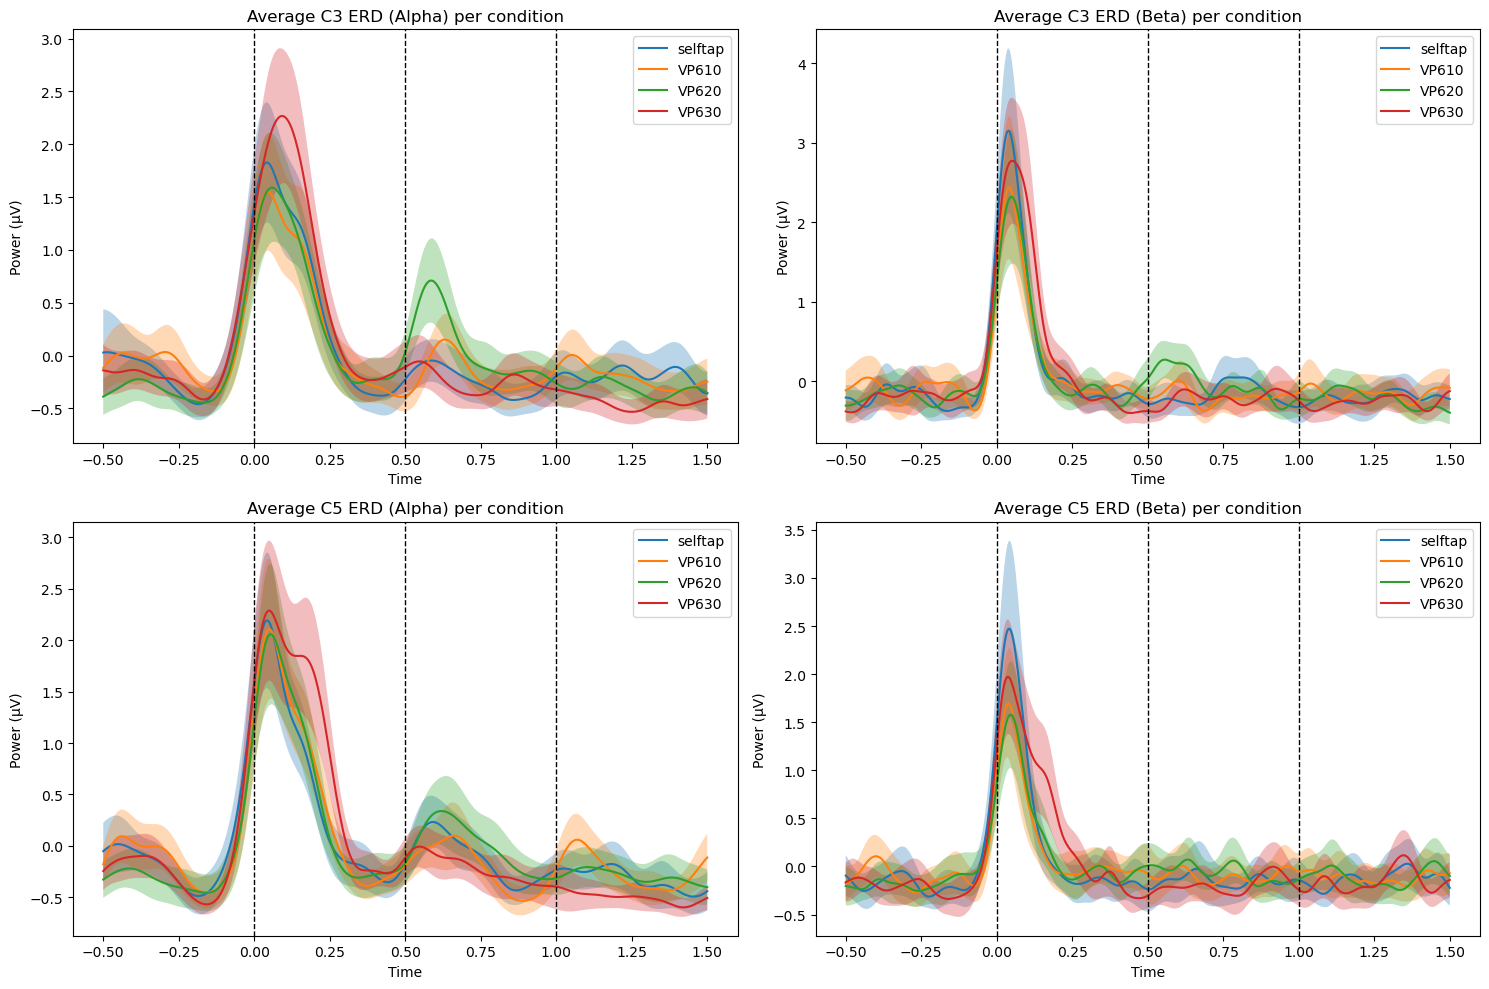

In [17]:
def plot_average_EVK_ERD_all_conditions(path, info, condition_names):
    conditions = condition_names
    #num_conditions = len(conditions)

    # lists to store average ERD values and confidence intervals for each condition and channel
    avg_C3_alpha_all = []
    avg_C3_alpha_ci_all = []
    avg_C3_beta_all = []
    avg_C3_beta_ci_all = []
    avg_C5_alpha_all = []
    avg_C5_alpha_ci_all = []
    avg_C5_beta_all = []
    avg_C5_beta_ci_all = []
    
    c3_index = get_channel_index(info, 'C3')
    c5_index = get_channel_index(info, 'C5')
    
    with h5py.File(path, 'r') as f:
        
        for condition_name, condition_group in f.items():
            condition_avg_C3_alpha = []
            condition_avg_C3_beta = []
            condition_avg_C5_alpha = []
            condition_avg_C5_beta = []
            
            for subject_group_name in condition_group.keys():
                subject_group = condition_group[subject_group_name]   
                
                if 'alpha' in subject_group and 'beta' in subject_group:
                    alpha = subject_group['alpha'][:]
                    beta = subject_group['beta'][:]
                    
                    condition_avg_C3_alpha.append(alpha[c3_index, :])
                    condition_avg_C3_beta.append(beta[c3_index, :])
                    condition_avg_C5_alpha.append(alpha[c5_index, :])
                    condition_avg_C5_beta.append(beta[c5_index, :])
                    
                    
            avg_C3_alpha = np.mean(condition_avg_C3_alpha, axis=0)
            ci_C3_alpha = 1.96 * sem(condition_avg_C3_alpha, axis=0)
            avg_C3_beta = np.mean(condition_avg_C3_beta, axis=0)
            ci_C3_beta = 1.96 * sem(condition_avg_C3_beta, axis=0)
        
            avg_C5_alpha = np.mean(condition_avg_C5_alpha, axis=0)
            ci_C5_alpha = 1.96 * sem(condition_avg_C5_alpha, axis=0)
            avg_C5_beta = np.mean(condition_avg_C5_beta, axis=0)
            ci_C5_beta = 1.96 * sem(condition_avg_C5_beta, axis=0)  
            
            avg_C3_alpha_all.append(avg_C3_alpha)
            avg_C3_alpha_ci_all.append(ci_C3_alpha)
            avg_C3_beta_all.append(avg_C3_beta)
            avg_C3_beta_ci_all.append(ci_C3_beta)
            avg_C5_alpha_all.append(avg_C5_alpha)
            avg_C5_alpha_ci_all.append(ci_C5_alpha)
            avg_C5_beta_all.append(avg_C5_beta)
            avg_C5_beta_ci_all.append(ci_C5_beta) 
            
    
    t = np.linspace(-0.5, 1.5, len(avg_C3_alpha_all[0]))

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot average C3 ERD across all conditions in alpha range with confidence intervals
    ax1 = axes[0, 0]
    for i, condition_name in enumerate(conditions):
        ax1.plot(t, avg_C3_alpha_all[i], label=condition_name.replace('_ERDs.h5', ''))
        ax1.fill_between(t, avg_C3_alpha_all[i] - avg_C3_alpha_ci_all[i], avg_C3_alpha_all[i] + avg_C3_alpha_ci_all[i], alpha=0.3)
    ax1.legend()
    ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax1.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
    ax1.axvline(x=1, color='black', linestyle='--', linewidth=1)
    ax1.set_title('Average C3 ERD (Alpha) per condition')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Power (µV)')
    
    # Plot average C3 ERD across all conditions in beta range with confidence intervals
    ax2 = axes[0, 1]
    for i, condition_name in enumerate(conditions):
        ax2.plot(t, avg_C3_beta_all[i], label=condition_name.replace('_ERDs.h5', ''))
        ax2.fill_between(t, avg_C3_beta_all[i] - avg_C3_beta_ci_all[i], avg_C3_beta_all[i] + avg_C3_beta_ci_all[i], alpha=0.3)
    ax2.legend()
    ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax2.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
    ax2.axvline(x=1, color='black', linestyle='--', linewidth=1)
    ax2.set_title('Average C3 ERD (Beta) per condition')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Power (µV)')

    # Plot average C5 ERD across all conditions in alpha range with confidence intervals
    ax3 = axes[1, 0]
    for i, condition_name in enumerate(conditions):
        ax3.plot(t, avg_C5_alpha_all[i], label=condition_name.replace('_ERDs.h5', ''))
        ax3.fill_between(t, avg_C5_alpha_all[i] - avg_C5_alpha_ci_all[i], avg_C5_alpha_all[i] + avg_C5_alpha_ci_all[i], alpha=0.3)
    ax3.legend()
    ax3.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax3.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
    ax3.axvline(x=1, color='black', linestyle='--', linewidth=1)
    ax3.set_title('Average C5 ERD (Alpha) per condition')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Power (µV)')

    # Plot average C5 ERD across all conditions in beta range with confidence intervals
    ax4 = axes[1, 1]
    for i, condition_name in enumerate(conditions):
        ax4.plot(t, avg_C5_beta_all[i], label=condition_name.replace('_ERDs.h5', ''))
        ax4.fill_between(t, avg_C5_beta_all[i] - avg_C5_beta_ci_all[i], avg_C5_beta_all[i] + avg_C5_beta_ci_all[i], alpha=0.3)
    ax4.legend()
    ax4.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax4.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
    ax4.axvline(x=1, color='black', linestyle='--', linewidth=1)
    ax4.set_title('Average C5 ERD (Beta) per condition')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('Power (µV)')
    
    plt.tight_layout()
    plt.show()
    
conditions =  ['selftap', 'VP610', 'VP620', 'VP630']
plot_average_EVK_ERD_all_conditions(file_path,info,conditions)

1280


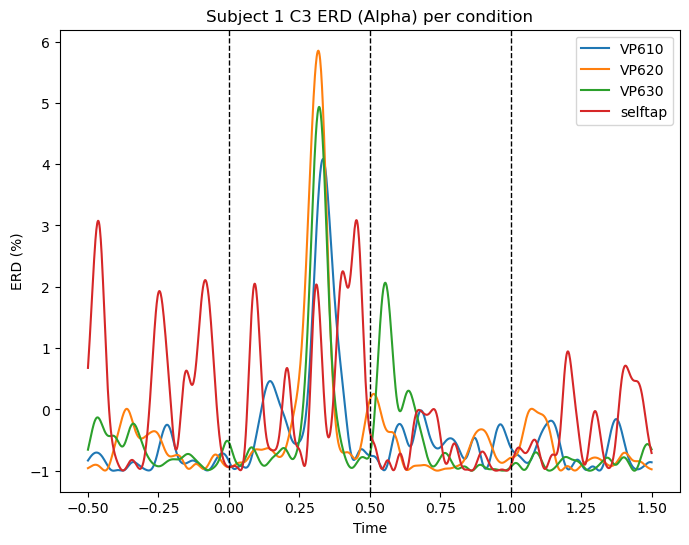

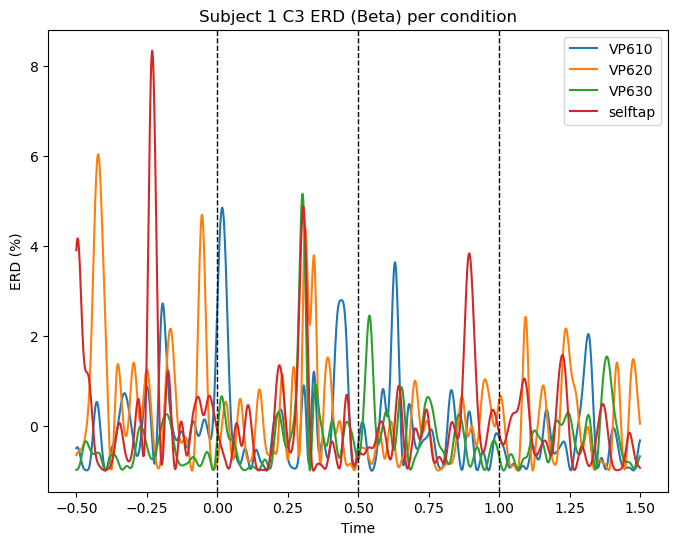

In [11]:

def plot_subject_ERD(file_path, subject_id, info):
    # Get channel indices
    c3_index = get_channel_index(info, 'C3')
    c5_index = get_channel_index(info, 'C5')
    
    if c3_index is None or c5_index is None:
        return

    # Initialize lists to store ERD values for each condition
    C3_alpha = []
    C3_beta = []
    C5_alpha = []
    C5_beta = []
    
    condition_names = []

    # Open the HDF5 file for all conditions
    with h5py.File(file_path, 'r') as f:
        for condition_name, condition_group in f.items():
            condition_names.append(condition_name)
            
            # Access data for the specified subject in the condition
            subject_group_name = f'subject_{subject_id}'
            if subject_group_name in condition_group:
                subject_group = condition_group[subject_group_name]
                if 'alpha' in subject_group and 'beta' in subject_group:
                    alpha = subject_group['alpha'][:]
                    beta = subject_group['beta'][:]
                    
                    C3_alpha.append(alpha[c3_index, :])
                    C3_beta.append(beta[c3_index, :])
                    C5_alpha.append(alpha[c5_index, :])
                    C5_beta.append(beta[c5_index, :])
    
    t = np.linspace(-0.5, 1.5, C3_alpha[0].shape[1])
    print(C3_alpha[0].shape[1])
    # Plot C3 ERD for alpha range across all conditions
    fig, ax1 = plt.subplots(figsize=(8, 6))
    for i, condition_name in enumerate(condition_names):
        ax1.plot(t, C3_alpha[i][1], label=condition_name)
    ax1.legend()
    ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax1.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
    ax1.axvline(x=1, color='black', linestyle='--', linewidth=1)
    ax1.set_title(f'Subject {subject_id} C3 ERD (Alpha) per condition')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('ERD (%)')
    plt.show()

    # Plot C3 ERD for beta range across all conditions
    fig, ax2 = plt.subplots(figsize=(8, 6))
    for i, condition_name in enumerate(condition_names):
        ax2.plot(t, C3_beta[i][1], label=condition_name)
    ax2.legend()
    ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax2.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
    ax2.axvline(x=1, color='black', linestyle='--', linewidth=1)
    ax2.set_title(f'Subject {subject_id} C3 ERD (Beta) per condition')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('ERD (%)')
    plt.show()
    
    

info = epochs.info

file_path = "D:/Mabel_Thesis/ERDs/All_Conditions_ERDs.h5"
subject_id = 1  # Change to the subject ID you want to plot

plot_subject_ERD(file_path, subject_id, info)


In [ ]:

from scipy.stats import sem
path2 = "C:/Users\Mabel Ife/OneDrive - Danmarks Tekniske Universitet/clean_epochs/subj_50-epo.fif"
epochs = mne.read_epochs(path2,preload=False)

info = epochs.info

plot_average_EVK_ERD_all_conditions(file_path,info,conditions)

# Cluster-based permetuation test 



In [13]:

def create_paired_X(con_data):
    conditions = list(con_data.keys())
    
    # Extracting data for each condition
    alpha_10 = con_data[conditions[0]]['alpha']
    alpha_20 = con_data[conditions[1]]['alpha']
    alpha_30 = con_data[conditions[2]]['alpha']
    beta_10 = con_data[conditions[0]]['beta']
    beta_20 = con_data[conditions[1]]['beta']
    beta_30 = con_data[conditions[2]]['beta']

    # Calculate paired differences for each comparison
    X_alpha_1020 = alpha_10 - alpha_20
    X_alpha_1030 = alpha_10 - alpha_30
    X_alpha_2030 = alpha_20 - alpha_30

    X_beta_1020 = beta_10 - beta_20
    X_beta_1030 = beta_10 - beta_30
    X_beta_2030 = beta_20 - beta_30

    # Create a list of tuples containing condition names and corresponding data
    pairs_to_compare = [
        (conditions[0], conditions[1], X_alpha_1020.transpose(0,2,1)),
        (conditions[0], conditions[2], X_alpha_1030.transpose(0,2,1)),
        (conditions[1], conditions[2], X_alpha_2030.transpose(0,2,1)),
        (conditions[0], conditions[1], X_beta_1020.transpose(0,2,1)),
        (conditions[0], conditions[2], X_beta_1030.transpose(0,2,1)),
        (conditions[1], conditions[2], X_beta_2030.transpose(0,2,1))
    ]


    No_diff_pair = [
    (conditions[0], conditions[1], [alpha_10.transpose(0, 2, 1), alpha_20.transpose(0, 2, 1)]),
    (conditions[0], conditions[2], [alpha_10.transpose(0, 2, 1), alpha_30.transpose(0, 2, 1)]),
    (conditions[1], conditions[2], [alpha_20.transpose(0, 2, 1), alpha_30.transpose(0, 2, 1)]),
    (conditions[0], conditions[1], [beta_10.transpose(0, 2, 1), beta_20.transpose(0, 2, 1)]),
    (conditions[0], conditions[2], [beta_10.transpose(0, 2, 1), beta_30.transpose(0, 2, 1)]),
    (conditions[1], conditions[2], [beta_20.transpose(0, 2, 1), beta_30.transpose(0, 2, 1)])
    ]
      

    return No_diff_pair, pairs_to_compare


def clustertest_prep_paired(path):
    data = {}

    with h5py.File(path, 'r') as f:
        for condition_name, condition_group in f.items():
            alp_data = []
            bet_data = []
            if condition_name == 'selftap':
                continue
            
            for subject_group_name in condition_group.keys():
                subject_group = condition_group[subject_group_name]   
                    
                if 'alpha' in subject_group and 'beta' in subject_group:
                    alpha = subject_group['alpha'][:]
                    beta = subject_group['beta'][:]
                    #print(f"{subject_group_name} alpha shape: {alpha.shape}")
                    #print(f"{subject_group_name} beta shape: {beta.shape}")
                    
                    t = np.linspace(-0.5, 1.5, alpha.shape[1])
                    interval_idx = np.where((t >= -0.25) & (t <= 0.50))[0]
                    
                    sub_alpha = alpha[:, interval_idx]
                    sub_beta = beta[:, interval_idx]
                    
                    alp_data.append(sub_alpha)
                    bet_data.append(sub_beta) 
                        
            data[condition_name]  = {
                'alpha': np.stack(alp_data),
                'beta': np.stack(bet_data)
            }  
      
    # Verifying and printing shapes for each condition and band
    for condition, condition_data in data.items():
        for band in ['alpha', 'beta']:
            print(f"{condition} - {band}: {condition_data[band].shape}")
    
    No_diff_pair, X_list = create_paired_X(data)         
             
    return X_list, No_diff_pair


file_path = "D:/Mabel_Thesis/ERDs/All_Conditions_new_ERDs.h5"
X_list, No_diff_pair = clustertest_prep_paired(file_path)
for cond1, cond2, X in X_list:
    
    print(X.shape)

VP610 - alpha: (44, 64, 193)
VP610 - beta: (44, 64, 193)
VP620 - alpha: (44, 64, 193)
VP620 - beta: (44, 64, 193)
VP630 - alpha: (44, 64, 193)
VP630 - beta: (44, 64, 193)
(44, 193, 64)
(44, 193, 64)
(44, 193, 64)
(44, 193, 64)
(44, 193, 64)
(44, 193, 64)


Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 64
__ __ __ __ __ New test __ __ ___ __ _
Now comparing: VP610 vs VP620
Differences in samples: (44, 193, 64)
Using a threshold of 2.016692
stat_fun(H1): min=-3.940402 max=2.709958
Running initial clustering …
Found 33 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

1
Significant cluster 1:
  p-value: 0.0391
  t-value range: -3.738356706893103 to -2.0247764940519106
print ch_inds length 11:
(64, 1)
Channels in the cluster:
['P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz']
combining channels using "gfp"
combining channels using "gfp"


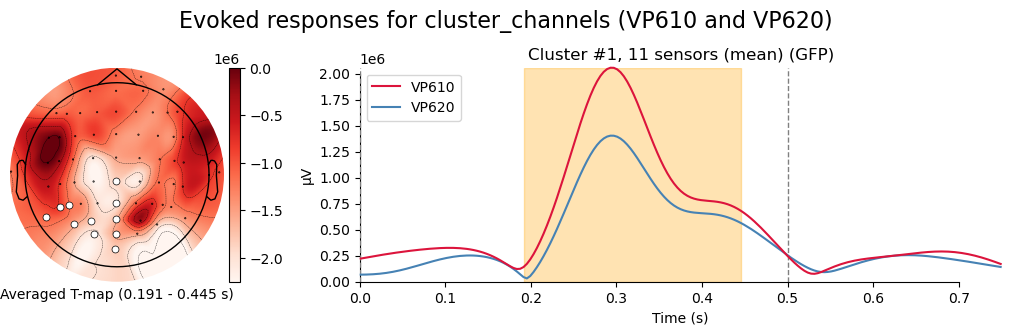

__ __ __ __ __ New test __ __ ___ __ _
Now comparing: VP610 vs VP630
Differences in samples: (44, 193, 64)
Using a threshold of 2.016692
stat_fun(H1): min=-4.087448 max=3.459239
Running initial clustering …
Found 28 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

1
Significant cluster 1:
  p-value: 0.0078
  t-value range: -3.946972965453527 to -2.024181507815976
print ch_inds length 14:
(64, 1)
Channels in the cluster:
['CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz']
combining channels using "gfp"
combining channels using "gfp"


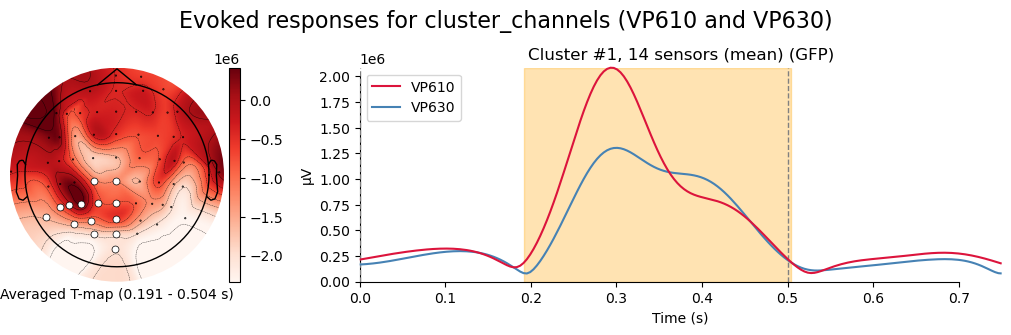

__ __ __ __ __ New test __ __ ___ __ _
Now comparing: VP620 vs VP630
Differences in samples: (44, 193, 64)
Using a threshold of 2.016692
stat_fun(H1): min=-3.314996 max=4.979158
Running initial clustering …
Found 21 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

1
__ __ __ __ __ New test __ __ ___ __ _
Now comparing: VP610 vs VP620
Differences in samples: (44, 193, 64)
Using a threshold of 2.016692
stat_fun(H1): min=-4.678249 max=3.454617
Running initial clustering …
Found 45 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

2
Significant cluster 1:
  p-value: 0.0010
  t-value range: -4.597205094559295 to -2.0200374562883407
Significant cluster 2:
  p-value: 0.0205
  t-value range: -3.8612076387016425 to -2.0222397128851433
Significant cluster 3:
  p-value: 0.0078
  t-value range: -4.678249326317398 to -2.0305273037296
print ch_inds length 34:
(64, 1)
Channels in the cluster:
['TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2']
combining channels using "gfp"
combining channels using "gfp"


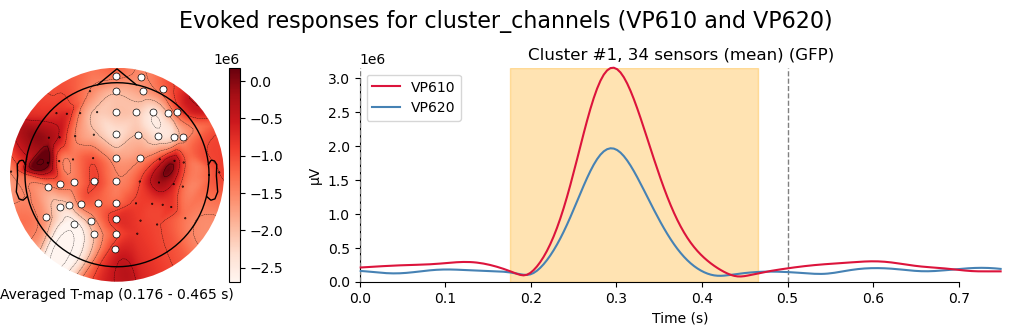

print ch_inds length 6:
(64, 1)
Channels in the cluster:
['FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5']
combining channels using "gfp"
combining channels using "gfp"


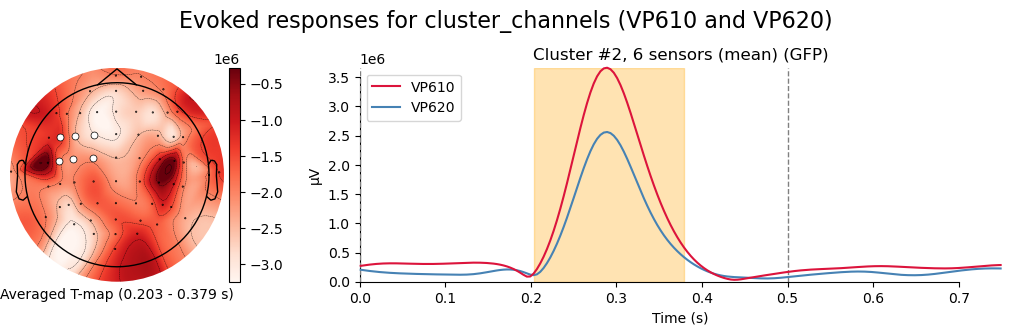

print ch_inds length 7:
(64, 1)
Channels in the cluster:
['A1', 'A2', 'AF3', 'F1', 'F3', 'F5', 'F7']
combining channels using "gfp"
combining channels using "gfp"


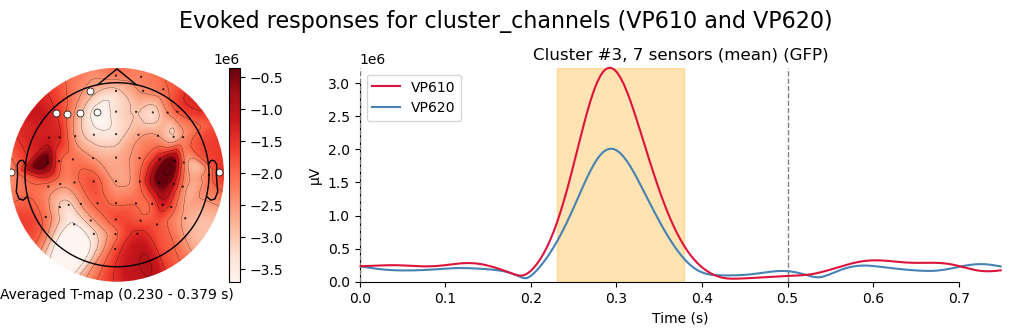

__ __ __ __ __ New test __ __ ___ __ _
Now comparing: VP610 vs VP630
Differences in samples: (44, 193, 64)
Using a threshold of 2.016692
stat_fun(H1): min=-5.184209 max=4.206436
Running initial clustering …
Found 37 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

3
Significant cluster 1:
  p-value: 0.0010
  t-value range: -5.084992078499337 to -2.0179978834027312
Significant cluster 2:
  p-value: 0.0010
  t-value range: -5.184209175141194 to -2.0208232722828314
Significant cluster 3:
  p-value: 0.0176
  t-value range: -4.248884621078281 to -2.018223399786321
print ch_inds length 31:
(64, 1)
Channels in the cluster:
['CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2']
combining channels using "gfp"
combining channels using "gfp"


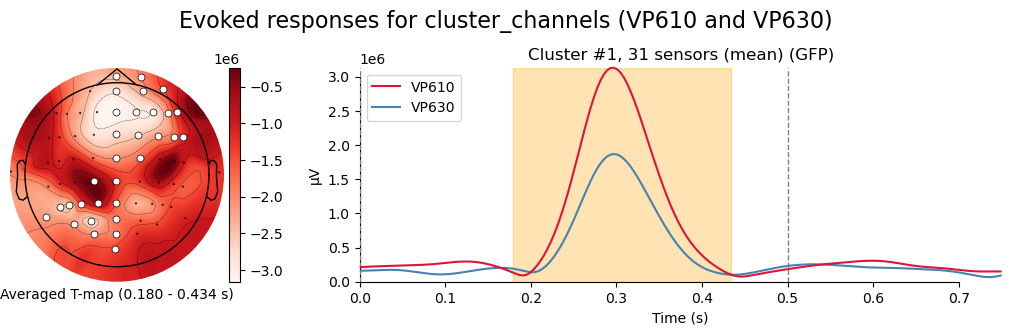

print ch_inds length 17:
(64, 1)
Channels in the cluster:
['A1', 'A2', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5']
combining channels using "gfp"
combining channels using "gfp"


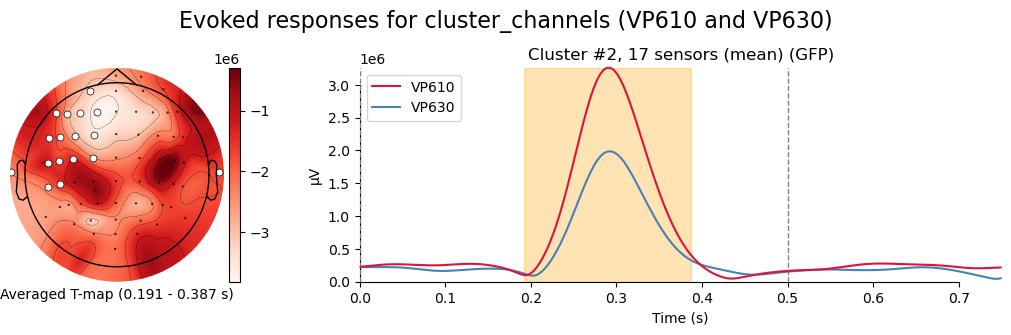

print ch_inds length 9:
(64, 1)
Channels in the cluster:
['CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
combining channels using "gfp"
combining channels using "gfp"


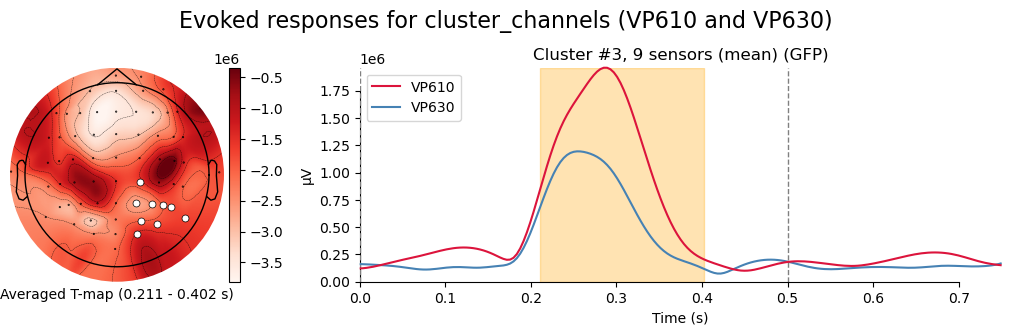

__ __ __ __ __ New test __ __ ___ __ _
Now comparing: VP620 vs VP630
Differences in samples: (44, 193, 64)
Using a threshold of 2.016692
stat_fun(H1): min=-4.056839 max=3.298023
Running initial clustering …
Found 42 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

3


In [246]:

from mne.stats import permutation_cluster_test
from mne.viz import plot_compare_evokeds
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from mne.stats import spatio_temporal_cluster_1samp_test, permutation_cluster_1samp_test
from mne.stats import ttest_1samp_no_p
import scipy.stats

def do_clustertest_paired(pairs_to_compare, info):
    alpha_level = 0.05  # significance level
    #tfce = dict(start=1, step=2)  # parameters for TFCE

    # Find channel adjacency
    adj, names = mne.channels.find_ch_adjacency(info, "eeg")
    
    df = 44 - 1  # degrees of freedom for the test
    thresh = scipy.stats.t.ppf(1 - alpha_level, df) 
   
    eeg_picks = mne.pick_types(info, eeg=True, stim=False, include=names ) # Select only EEG channels
    i=0
    for cond1, cond2, X in pairs_to_compare:
        print("__ __ __ __ __ New test __ __ ___ __ _")
    
        print(f'Now comparing: {cond1} vs {cond2}')
        X_diff = X[1]-X[0]
        print(f"Differences in samples: {X_diff.shape}")
        
    
        
        # Perform the cluster-based permutation test
        T_obs, clusters, cluster_pv, H0 = spatio_temporal_cluster_1samp_test(
            X_diff, n_permutations=1024, tail=0, adjacency=None, threshold=None, n_jobs=1)
        
        i = i+1
        print(i)
        good_cluster_inds = np.where(cluster_pv < alpha_level)[0]
        for i, cluster_idx in enumerate(good_cluster_inds):
                print(f"Significant cluster {i + 1}:")
                print(f"  p-value: {cluster_pv[cluster_idx]:.4f}")
                print(f"  t-value range: {T_obs[clusters[cluster_idx]].min()} to {T_obs[clusters[cluster_idx]].max()}")
                
          # Convert data to MNE Evoked objects
         # Create a directory to save the figures
        #save_dir = "clusterbased"
        #os.makedirs(save_dir, exist_ok=True)
        
        data_cond1 = np.mean(X[0], axis=0)  # Average across subjects
        data_cond2 = np.mean(X[1], axis=0)  # Average across subjects       
        
        if good_cluster_inds.size > 0:
            
            colors = {cond1: "crimson", cond2: "steelblue"}
            linestyles = {cond1: "-", cond2: "-"}

            

            evokeds = {
                cond2: mne.EvokedArray(data_cond2.transpose(1,0), mne.pick_info(info, eeg_picks)),
                cond1: mne.EvokedArray(data_cond1.transpose(1,0), mne.pick_info(info, eeg_picks)),
            }

          
            for i_clu, clu_idx in enumerate(good_cluster_inds):
                
                time_inds, space_inds = np.squeeze(clusters[clu_idx])
                ch_inds = np.unique(space_inds)
                print(f"print ch_inds length {len(ch_inds)}:")
                #print(space_inds.shape)
                time_inds = np.unique(time_inds)
                #print(T_obs.shape)
                #_= T_obs.transpose(1,0)
                t_map = T_obs[time_inds, ...].mean(axis=0)
                #print(f"shape of f-map: {f_map.shape}") 
                sig_times = evokeds[cond1].times[time_inds]
                #print(f"shape of f-map {f_map.shape[0]}")
                mask = np.zeros((t_map.shape[0], 1), dtype=bool)
                print(mask.shape)
                mask[ch_inds, :] = True
                
                
                cluster_channel_names = [names[ch] for ch in ch_inds]
            
                if len(ch_inds) > 35:
                    print(f"Cluster {i + 1} contains more than 35 channels.")
                    non_cluster_channels = [ch_name for ch_name in names if ch_name not in cluster_channel_names]
                    print("Channels not in the cluster:")
                    print(non_cluster_channels)
                else:
                    print("Channels in the cluster:")
                    print(cluster_channel_names)

                
                

                fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3), layout="constrained")
                #_= f_map.transpose(0,1)
                t_evoked = mne.EvokedArray(t_map[:, np.newaxis], mne.pick_info(info, eeg_picks), tmin=0)
                t_evoked.plot_topomap(
                    times=0,
                    mask=mask,
                    axes=ax_topo,
                    cmap="Reds",
                    vlim=(np.min, np.max),
                    show=False,
                    colorbar=False,
                    mask_params=dict(markersize=10),
                )
                image = ax_topo.images[0]
                ax_topo.set_title("")

                divider = make_axes_locatable(ax_topo)
                ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(image, cax=ax_colorbar)
                ax_topo.set_xlabel(
                    "Averaged T-map ({:0.3f} - {:0.3f} s)".format(*sig_times[[0, -1]])
                )

                ax_signals = divider.append_axes("right", size="300%", pad=1.2)
                title = f"Cluster #{i_clu + 1}, {len(ch_inds)} sensor"
                if len(ch_inds) > 1:
                    title += "s (mean)"
                plot_compare_evokeds(
                    evokeds,
                    title=title,
                    picks=ch_inds,
                    axes=ax_signals,
                    colors=colors,
                    linestyles=linestyles,
                    show=False,
                    split_legend=True,
                    truncate_yaxis="auto",
                )

                ax_signals.axvline(x=0, color='gray', linestyle='--', linewidth=1)
                ax_signals.axvline(x=0.5, color='gray', linestyle='--', linewidth=1)
                ax_signals.axvline(x=1, color='gray', linestyle='--', linewidth=1)
                
                ymin, ymax = ax_signals.get_ylim()
                ax_signals.fill_betweenx(
                    (ymin, ymax), sig_times[0], sig_times[-1], color="orange", alpha=0.3
                )
                
                
                
                fig.suptitle(f"Evoked responses for cluster_channels ({cond1} and {cond2})", fontsize=16, y=1.05)
                plt.show()
            
            
                    

           

do_clustertest_paired(No_diff_pair,info)

# Evoked ERDS without baseline correction

In [ ]:
plot_average_EVK_ERD_all_conditions(file_path,info,conditions)

# Linear Mixed Effetcs Model

In [14]:
def LMM_prep(path, df_BPT, info):
    
    condition_dfs_alp = {}
    condition_dfs_bet = {} 
    c3_index = get_channel_index(info, 'C3')
    
    with h5py.File(path, 'r') as f:
        for condition_name, condition_group in f.items():
            data_list_alp = []
            data_list_bet = []
            if condition_name == 'selftap':
                continue
            
            for subject_group_name in condition_group.keys():
                subject_group = condition_group[subject_group_name]
                
                if 'alpha' in subject_group and 'beta' in subject_group:
                    alpha = subject_group['alpha'][:]
                    beta = subject_group['beta'][:]
                    
                    t = np.linspace(-0.5, 1.5, alpha.shape[1])
                    interval_idx = np.where((t >= -0.25) & (t <= 0.50))[0]
                    
                    alf = alpha[c3_index, interval_idx]
                    bet = beta[c3_index, interval_idx]
                    
                    subject_number = int(subject_group_name.replace('subject_', ''))
                    
                    # Append alpha data
                    data_list_alp.append([subject_number, np.mean(alf)])
                    
                    # Append beta data
                    data_list_bet.append([subject_number, np.mean(bet)])

            # Creates a DataFrame for the condition
            condition_df1 = pd.DataFrame(data_list_alp, columns=["Subject", "Mean_ERD"])
            condition_df2 = pd.DataFrame(data_list_bet, columns=["Subject", "Mean_ERD"])
        
            # Sorts by 'Subject' to maintain order
            condition_df1 = condition_df1.sort_values(by='Subject').reset_index(drop=True)
            condition_df2 = condition_df2.sort_values(by='Subject').reset_index(drop=True)
            
            # Converts 'Subject' in df_BPT to integer and filter subjects
            df_BPT['ID'] = df_BPT['ID'].astype(int)
            df_BPT_filtered = df_BPT[df_BPT['ID'].isin(condition_df1['Subject'])]

            # Sorts df_BPT_filtered by 'ID' 
            df_BPT_filtered = df_BPT_filtered.sort_values(by='ID').reset_index(drop=True)

            # Merge with BPT traits, ensuring order is preserved
            merged_df1 = pd.merge(condition_df1, df_BPT_filtered, left_on='Subject', right_on='ID')
            merged_df2 = pd.merge(condition_df2, df_BPT_filtered, left_on='Subject', right_on='ID')
            
            merged_df1 = merged_df1.drop(columns=['ID'])
            merged_df2 = merged_df2.drop(columns=['ID'])
        
            # Store the dataframe in the dictionary
            condition_dfs_alp[condition_name] = merged_df1
            condition_dfs_bet[condition_name] = merged_df2
        
    # Dataframes for all conditions into one dataframe
    all_conditions_alp = pd.concat(condition_dfs_alp.values(), keys=condition_dfs_alp.keys(), names=['Condition', 'Index']).reset_index(level='Condition')
    all_conditions_bet = pd.concat(condition_dfs_bet.values(), keys=condition_dfs_bet.keys(), names=['Condition', 'Index']).reset_index(level='Condition')
    
    # Output the results for debugging
    print(f"Final dataframe alpha: {all_conditions_alp.head(44)}")
    print(f"Final dataframe beta: {all_conditions_bet.head(44)}")
    
    # S

# Run the function with provided file paths and data
file_path = "D:/Mabel_Thesis/ERDs/All_Conditions_new_ERDs.h5"
df_BPT = pd.read_excel('db.xlsx')
 
LMM_prep(file_path, df_BPT, info)


Final dataframe alpha:       Condition  Subject  Mean_ERD  Mean_traits
Index                                          
0         VP610        1  0.659296     1.583333
1         VP610        2  0.142400     1.833333
2         VP610        3  0.116015     2.041667
3         VP610        4  0.906673     2.125000
4         VP610        5  0.043061     2.375000
5         VP610        7 -0.029016     3.250000
6         VP610        8  0.410382     1.666667
7         VP610       10  0.420448     2.125000
8         VP610       11  0.100967     2.291667
9         VP610       12  0.406752     2.041667
10        VP610       13  0.128678     1.791667
11        VP610       14  0.933672     1.541667
12        VP610       15  0.266305     2.041667
13        VP610       16  0.735647     3.125000
14        VP610       17 -0.517264     1.500000
15        VP610       18  1.041164     1.750000
16        VP610       20  0.183173     2.666667
17        VP610       21  0.916126     1.916667
18        VP610  